In [1]:
# Standard libraries
import re  # Regular expression operations
from configparser import ConfigParser  # Configuration file parser

# Numerical and mathematical operations
import numpy as np
import math, random

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.collections as clct
from matplotlib.axes import Axes

# Geometric operations and shapes
from shapely.geometry import LineString, Point, MultiPoint, Polygon
from shapely import affinity

# Statistical operations
import scipy.stats as stat

# Typing and data structures
from typing import List, Tuple
from scipy.spatial import Delaunay

# Iteration tools
import itertools

In [2]:
# Constants

# Fixed beacon range (in meters)
B_RANGE = 5.0 

# Resolution of display functions (the step size for plotting)
DELTA = 0.2 

# Frequency for the wireless signals (2.4 GHz is typical for WiFi and BLE)
f = 2400e6  

# Speed of light (in meters per second)
c = 3e8    

# Reference distance for the path loss model (in meters)
d0 = 1.0   

# Power at the reference distance (in dBm) based on a specific path loss model
P0 = -40.0     

# Path loss exponent, chosen to represent typical indoor environments
n = 4     

# Resolution of the signal map, which determines the granularity of computations or visualizations
step = DELTA  

# Sensitivity of the transmitting beacon in dBm. It's computed considering a noise floor and the beacon's power.
sens = -84   

In [3]:
def get_layout(file_path: str) -> List[dict]:
    """
    Generate a floorplan layout based on the data provided in a config file.
    
    Parameters:
    - file_path (str): Path to the .lay config file that contains layout details.
    
    Returns:
    - List[dict]: A list of wall dictionaries, where each dictionary contains details
                  about the wall's start and end points, material properties, attenuation,
                  and type.
    
    Example of returned wall dictionary:
    {
        'start': (x1, y1),
        'end': (x2, y2),
        'material': { ... },
        'attenuation': value,
        'type': wall_type
    }
    """
    
    # Read the .lay file content from the provided file path
    with open(file_path, 'r') as f:
        lay_content = f.read()

    # Initialize ConfigParser and read the .lay content
    config = ConfigParser(allow_no_value=True)
    config.read_string(lay_content)

    # Extract and store point coordinates from the config
    points = {}
    for point_id, coords in config.items('points'):
        x, y = map(float, re.findall(r"[-+]?\d*\.\d+|\d+", coords))
        points[int(point_id)] = (x, y)

    # Extract and store material properties from the config
    materials = {}
    for material_name, material_info in config.items('materials'):
        materials[material_name] = eval(material_info)

    # Extract segments from the config and convert them to wall dictionaries
    walls = []
    for segment_id, segment_info in config.items('segments'):
        segment_dict = eval(segment_info)
        
        # Adjust coordinates for specific file layouts
        if file_path == 'layout2.lay':
            start_point = tuple(coord / 2 for coord in points[segment_dict['connect'][0]])
            end_point = tuple(coord / 2 for coord in points[segment_dict['connect'][1]])
        else:
            start_point = points[segment_dict['connect'][0]]
            end_point = points[segment_dict['connect'][1]]
        
        # Extract material properties for the segment (wall)
        material_name = segment_dict.get('name').lower()
        material_properties = materials.get(material_name, {})
        attenuation = material_properties.get('attenuation', 0)
        wall_type = material_properties.get('type', 'unknown')

        # Construct wall dictionary and append to the walls list
        wall = {
            'start': start_point,
            'end': end_point,
            'material': material_properties,
            'attenuation': attenuation,
            'type': wall_type
        }
        walls.append(wall)
    
    return walls

In [4]:
def get_hull(walls: List[dict]) -> Polygon:
    """
    Calculate the convex hull of a given layout. For convex layouts, this function
    returns the external walls.

    Parameters:
    - walls (List[dict]): A list of wall dictionaries, where each dictionary contains 
                          details about the wall's start and end points.

    Returns:
    - Polygon: A Shapely Polygon object representing the convex hull of the layout.
    
    """
    
    # Collect all start and end points from the walls
    all_points = []
    for wall in walls:
        all_points.append(wall['start'])
        all_points.append(wall['end'])

    # Create a MultiPoint object from the collected points
    multi_point = MultiPoint(all_points)

    # Calculate and return the Convex Hull of the MultiPoint object
    return multi_point.convex_hull


In [5]:
def get_geometry(poly: Polygon) -> Tuple[float, float, float, float, float, float, float]:
    """
    Extract geometric properties of a given polygon. This function calculates and
    returns the bounding box of the polygon, its dimensions, and the area of the bounding box.

    Parameters:
    - poly (Polygon): A Shapely Polygon object for which geometric properties are to be extracted.

    Returns:
    - Tuple: A tuple containing the following values in order:
        min_x (float): Minimum x-coordinate of the bounding box.
        min_y (float): Minimum y-coordinate of the bounding box.
        max_x (float): Maximum x-coordinate of the bounding box.
        max_y (float): Maximum y-coordinate of the bounding box.
        delta_x (float): Width of the bounding box.
        delta_y (float): Height of the bounding box.
        bounds_area (float): Area of the bounding box.

    Example Usage:
    This function can be typically used with the result from the `get_hull` function to ensure
    that when generating wireless beacon positions, they are placed within the layout bounds.
    """

    # Calculate the bounding box of the polygon
    min_x, min_y, max_x, max_y = poly.bounds

    # Calculate the width and height of the bounding box
    delta_x = max_x - min_x
    delta_y = max_y - min_y

    # Calculate the area of the bounding box
    bounds_area = delta_x * delta_y

    return (min_x, min_y, max_x, max_y, delta_x, delta_y, bounds_area)

In [6]:
def generate_triangle_lattice(r=B_RANGE) -> np.array:
    """
    Generate a lattice of beacon positions well around the boundary of a given layout. 
    The lattice is generated in a staggered manner to ensure uniform coverage around the layout.

    Parameters:
    - r (float, optional): Spacing between the beacons in the lattice. Defaults to the value of B_RANGE.

    Returns:
    - np.array: An array of Shapely Point objects representing beacon positions in the lattice.

    Note:
    The function uses global constants such as B_RANGE, MIN_Y, MAX_Y, MIN_X, and MAX_X 
    to determine the bounds and spacing for the lattice generation.
    """

    # Extend the starting and ending bounds for y-axis based on the beacon range and angle
    start_y = MIN_Y - 10 * abs(B_RANGE * np.sin(np.pi/3))
    end_y = MAX_Y + 10 * abs(B_RANGE * np.sin(np.pi/3))

    # Extend the starting and ending bounds for x-axis based on the beacon range
    start_x = MIN_X - 10 * B_RANGE
    end_x = MAX_X + 10 * B_RANGE

    # Initialize the list to store the beacon positions
    lattice = []
    i = 0

    # Generate the lattice of beacon positions
    for y in np.arange(start_y, end_y, r * np.sin(np.pi/3)):
        for x in np.arange(start_x, end_x + r, r):
            # For every alternate row in the lattice, offset the x-coordinate
            if(i % 2 == 1):
                lattice.append(Point([x + r/2, y]))
            else:
                lattice.append(Point([x, y]))
        i += 1

    return np.array(lattice)

In [7]:
def generate_trihex_lattice() -> np.array:
    """
    Generate a tri-hexagonal lattice of beacon positions. This function first generates
    a base lattice and then a larger lattice with twice the beacon range. Beacons that 
    exist in both lattices are then filtered out to create the final tri-hexagonal lattice.
    
    Returns:
    - np.array: An array of Shapely Point objects representing beacon positions in the tri-hexagonal lattice.
    """
    
    # Generate a base lattice with default beacon spacing
    lattice = generate_triangle_lattice()

    # Generate a larger lattice with twice the beacon range
    large_lattice = generate_triangle_lattice(2 * B_RANGE)

    # Initialize an array to keep track of which beacons to retain
    keep = np.ones(len(lattice), dtype=bool)

    # Filter out beacons that exist in both the base and larger lattice
    for i in range(len(lattice)):
        for j in range(len(large_lattice)):
            if lattice[i].equals_exact(large_lattice[j], 0.001):
                keep[i] = False
                break

    # Return the final tri-hexagonal lattice
    return lattice[keep]

In [8]:
def free_space_path_loss(d: float, Ptx: float) -> float:
    """
    Calculate the received signal strength using the free space path loss model.

    Parameters:
    - d (float): Distance between the transmitter and receiver.
    - Ptx (float): Transmission power of the beacon.

    Returns:
    - float: Calculated signal strength at the receiver based on the free space path loss model.
    """
    
    # If the distance is less than the reference distance, adjust the signal strength
    if d < d0: 
        return Ptx + P0
    
    # Calculate the signal strength using the free space path loss model
    return Ptx + P0 - 10 * n * np.log10(d/d0)

In [9]:
def signal_strength(tx: Tuple[float, float], rx: Tuple[float, float], walls: List[dict], Ptx: float) -> float:
    """
    Calculate the received signal strength considering the attenuation due to walls.

    Parameters:
    - tx (Tuple[float, float]): Coordinates of the transmitter (beacon).
    - rx (Tuple[float, float]): Coordinates of the receiver.
    - walls (List[dict]): List of wall dictionaries containing details about the wall's 
                          start and end points, material properties, attenuation, and type.
    - Ptx (float): Transmission power of the beacon.

    Returns:
    - float: Calculated signal strength at the receiver after considering wall attenuations.
    """
    
    # Initialize attenuation to zero
    attenuation = 0
    
    # Define the direct path between transmitter and receiver
    path = LineString([tx, rx])
    
    # Calculate total attenuation due to walls intersecting the direct path
    for wall in walls:
        # Skip external walls to avoid potential bugs due to rounding errors
        if wall['type'] == 'external':
            continue
        wall_line = LineString([wall['start'], wall['end']])
        if path.intersects(wall_line):
            attenuation += wall['attenuation']

    # Calculate the distance between the transmitter and receiver
    distance = Point(tx).distance(Point(rx))
    
    # Return the signal strength after considering free space path loss and wall attenuation
    return free_space_path_loss(distance, Ptx) - attenuation

In [10]:
def find_tx_power(d0: float, P0: float, n: float, sensitivity: float, d: float) -> float:
    """
    Calculate the required transmission power given a desired beacon range.

    Parameters:
    - d0 (float): Reference distance for the path loss model.
    - P0 (float): Power at the reference distance.
    - n (float): Path loss exponent.
    - sensitivity (float): Sensitivity of the transmitting beacon.
    - d (float): Desired beacon range.

    Returns:
    - float: Calculated transmission power required to achieve the desired beacon range.
    """
    
    # Calculate the required transmission power using the provided formula
    return sensitivity - P0 + 10 * n * np.log10(d/d0)

In [11]:
def adjust_beacon_power(beacons: List[Tuple[float, float]], walls: List[dict], POLY: Polygon) -> np.array:
    """
    Adjust the power of each beacon to ensure a minimum distance of the desired beacon range,
    considering the effects of surrounding walls.

    Parameters:
    - beacons (List[Tuple[float, float]]): List of beacon positions.
    - walls (List[dict]): List of wall dictionaries containing details about the wall's 
                          start and end points, material properties, attenuation, and type.
    - POLY (Polygon): Polygon representing the external boundaries of the area.

    Returns:
    - np.array: Array of adjusted beacon powers.
    """
    
    # List to store the adjusted powers for each beacon
    adjusted_powers = []

    for beacon in beacons:
        min_strength = float('inf')  # Initialize minimum strength to infinity

        # Generate points along the circumference of a circle centered at the beacon
        theta = np.linspace(0, 2*np.pi, 1000)
        circle_x = (B_RANGE+0.1) * np.cos(theta) + beacon[0] 
        circle_y = (B_RANGE+0.1) * np.sin(theta) + beacon[1]
        circle_points = list(zip(circle_x, circle_y))

        # Filter points that are within the external walls
        circle_points = [point for point in circle_points if POLY.contains(Point(point))]

        for point in circle_points:
            # Calculate the signal strength at the point considering surrounding walls
            strength = signal_strength(beacon, point, walls, beacon_powers[beacons.index(beacon)])
            min_strength = min(min_strength, strength)

        # Adjust the beacon's power such that the minimum signal strength is above the sensitivity level
        power_adjustment = sens - min_strength
        adjusted_power = beacon_powers[beacons.index(beacon)] + max(0, power_adjustment)
        adjusted_powers.append(adjusted_power)

    return np.array(adjusted_powers)

In [12]:
def plot_localizability_map(ax: Axes, 
                            X: np.ndarray, 
                            Y: np.ndarray, 
                            beacons: List[Tuple[float, float]], 
                            walls: List[dict], 
                            beacon_powers: List[float], 
                            MIN_X: float, 
                            MAX_X: float, 
                            MIN_Y: float, 
                            MAX_Y: float) -> None:
    """
    Plot a localizability map of the layout. The function determines if a given point in the layout
    is localizable based on the surrounding beacon signal strengths and the number of beacons that
    can sense the point.

    Parameters:
    - ax (Axes): The matplotlib axis on which to plot the localizability map.
    - X, Y (np.ndarray): Grid arrays representing x and y coordinates of the layout.
    - beacons (List[Tuple[float, float]]): List of beacon positions.
    - walls (List[dict]): List of wall dictionaries containing details about each wall.
    - beacon_powers (List[float]): List of transmission powers for each beacon.
    - MIN_X, MAX_X, MIN_Y, MAX_Y (float): Boundary values for the layout.

    Note:
    A point is considered localizable if it is sensed by more than 3 beacons with a 
    signal strength above the threshold, or if all the close beacons have a signal 
    strength above the threshold.
    """

    # Initialize an array to store localizability information
    localizable = np.zeros_like(X, dtype=bool)

    # Loop through each point in the layout to determine its localizability
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            rx = (X[i, j], Y[i, j])
            rx_point = Point(rx)

            # Find beacons within the desired range
            close_beacons = [beacon for beacon in beacons if rx_point.distance(Point(beacon)) <= B_RANGE]

            # Get the corresponding powers for these beacons
            close_beacon_powers = [beacon_powers[beacons.index(beacon)] for beacon in close_beacons]

            # Check the signal strength from these beacons to determine localizability
            if close_beacons:
                strengths = [signal_strength(beacon, rx, walls, Ptx) for beacon, Ptx in zip(close_beacons, close_beacon_powers)]
                
                # Check for localization criteria
                if len(strengths) > 3:
                    if sum(strength > sens for strength in strengths) >= 3:
                        localizable[i, j] = True
                else:
                    if all(strength > sens for strength in strengths):
                        localizable[i, j] = True

    # Define custom colors for the plot: red for non-localizable and green for localizable points
    cmap = mcolors.ListedColormap(['#FF6961', '#77DD77'])

    # Plot the localizability map on the given axis
    ax.imshow(localizable, extent=[MIN_X, MAX_X, MIN_Y, MAX_Y], origin='lower', cmap=cmap, vmin=0, vmax=1)

    # Set title and maintain aspect ratio
    ax.set_title("Localizability Map")
    ax.set_aspect('equal', adjustable='box')

In [13]:
def plot_walls(ax: Axes, walls: List[dict]) -> None:
    """
    Plot the walls on the provided axis.

    Parameters:
    - ax (Axes): The matplotlib axis on which to plot the walls.
    - walls (List[dict]): List of wall dictionaries containing details about 
                          each wall's start and end points, and material properties.

    The color and linewidth of each wall is determined by its material properties.
    """
    
    for wall in walls:
        start, end = wall['start'], wall['end']
        material = wall['material']
        color = material.get('color', 'black')  # Default to black if color is not provided
        linewidth = material.get('linewidth', 1)  # Default to 1 if linewidth is not provided
        ax.plot([start[0], end[0]], [start[1], end[1]], color=color, linewidth=linewidth)

In [14]:
def plot_coverage(ax: Axes, X: np.ndarray, Y: np.ndarray, Z: np.ndarray, vmin=None, vmax: int = 0) -> None:
    """
    Plot the coverage map on the provided axis.

    Parameters:
    - ax (Axes): The matplotlib axis on which to plot the coverage map.
    - X, Y (np.ndarray): Grid arrays representing x and y coordinates of the layout.
    - Z (np.ndarray): Array representing signal strength at each grid point.
    - vmin (optional): Minimum value of the colormap scale.
    - vmax (int, default=0): Maximum value of the colormap scale.
    """
    
    quadmesh = ax.pcolormesh(X, Y, Z, shading='auto', cmap='rainbow', vmin=None, vmax=0)
    plt.colorbar(quadmesh, ax=ax, label="Signal Strength (dB)")

In [15]:
def plot_beacons(ax: Axes, beacons: List[Tuple[float, float]]) -> None:
    """
    Plot the beacons on the provided axis.

    Parameters:
    - ax (Axes): The matplotlib axis on which to plot the beacons.
    - beacons (List[Tuple[float, float]]): List of beacon positions.

    Beacons are plotted as red 'x' markers.
    """
    
    for beacon in beacons:
        ax.scatter(*beacon, color='red', s=100, marker='x')

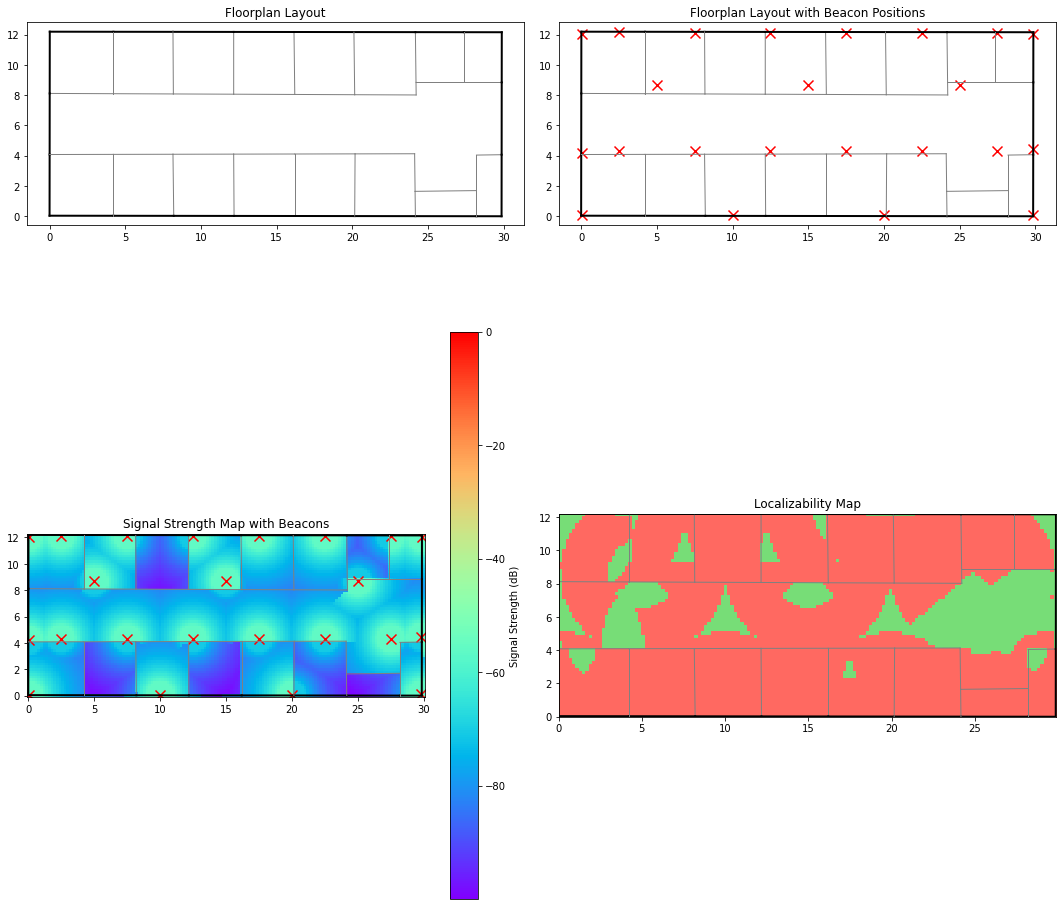

In [16]:
# Load layout and extract walls from the provided layout file
walls = get_layout('layout2.lay')

# Extract the external boundary of the layout (convex hull)
POLY = get_hull(walls)

# Get geometric properties of the layout
MIN_X, MIN_Y, MAX_X, MAX_Y, DELTA_X, DELTA_Y, BOUND_AREA = get_geometry(POLY)

# Generate the lattice of beacon positions
UL_lattice = generate_trihex_lattice()

# Filter lattice points to retain only those close to the layout
close_lattice = np.array([lattice_point.within(POLY.buffer((np.sqrt(3)/2) * B_RANGE)) for lattice_point in UL_lattice])

# Filter further to get the final list of beacon positions
minimum_lattice = UL_lattice[close_lattice]

# Adjust lattice points that are outside the layout to bring them inside
for i in range(len(minimum_lattice)):
    if not minimum_lattice[i].within(POLY):
        new_point = minimum_lattice[i].buffer(minimum_lattice[i].distance(POLY.boundary)+0.1).intersection(POLY).point_on_surface()
        minimum_lattice[i] = new_point

# Convert the filtered lattice points to beacon coordinates
beacons = [(b.x, b.y) for b in minimum_lattice]

# Assume each beacon has a certain transmission power
beacon_powers = [find_tx_power(d0, P0, n, sens, B_RANGE) for _ in range(len(beacons))]

# Define the area for plotting
X = np.arange(MIN_X, MAX_X + step, step)
Y = np.arange(MIN_Y, MAX_Y + step, step)
X, Y = np.meshgrid(X, Y)

# Calculate the signal strength for each point in the layout considering all beacons
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        rx = (X[i,j], Y[i,j])
        strength = [signal_strength(beacon, rx, walls, Ptx) for beacon, Ptx in zip(beacons, beacon_powers)]
        Z[i,j] = max(strength)  # Considering the strongest signal only

# Create a new figure and plot all the required plots in different subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))  # 2x2 grid of subplots

# Plot walls on the first subplot
plot_walls(axs[0, 0], walls)
axs[0, 0].set_title("Floorplan Layout")
axs[0, 0].set_aspect('equal', adjustable='box')

# Plot walls and beacon positions on the second subplot
plot_walls(axs[0, 1], walls)
plot_beacons(axs[0, 1], beacons)
axs[0, 1].set_title("Floorplan Layout with Beacon Positions")
axs[0, 1].set_aspect('equal', adjustable='box')

# Plot the coverage map on the third subplot
plot_walls(axs[1, 0], walls)
plot_coverage(axs[1, 0], X, Y, Z, vmin=sens, vmax=0)
plot_beacons(axs[1, 0], beacons)
axs[1, 0].set_title("Signal Strength Map with Beacons")
axs[1, 0].set_aspect('equal', adjustable='box')


# Plot the localizability map on the fourth subplot
plot_walls(axs[1, 1], walls)
plot_localizability_map(axs[1, 1], X, Y, beacons, walls, beacon_powers, MIN_X, MAX_X, MIN_Y, MAX_Y)
axs[1, 1].set_title("Localizability Map")
axs[1, 1].set_aspect('equal', adjustable='box')

# Adjust spacing between subplots for clarity
plt.tight_layout()
plt.show()


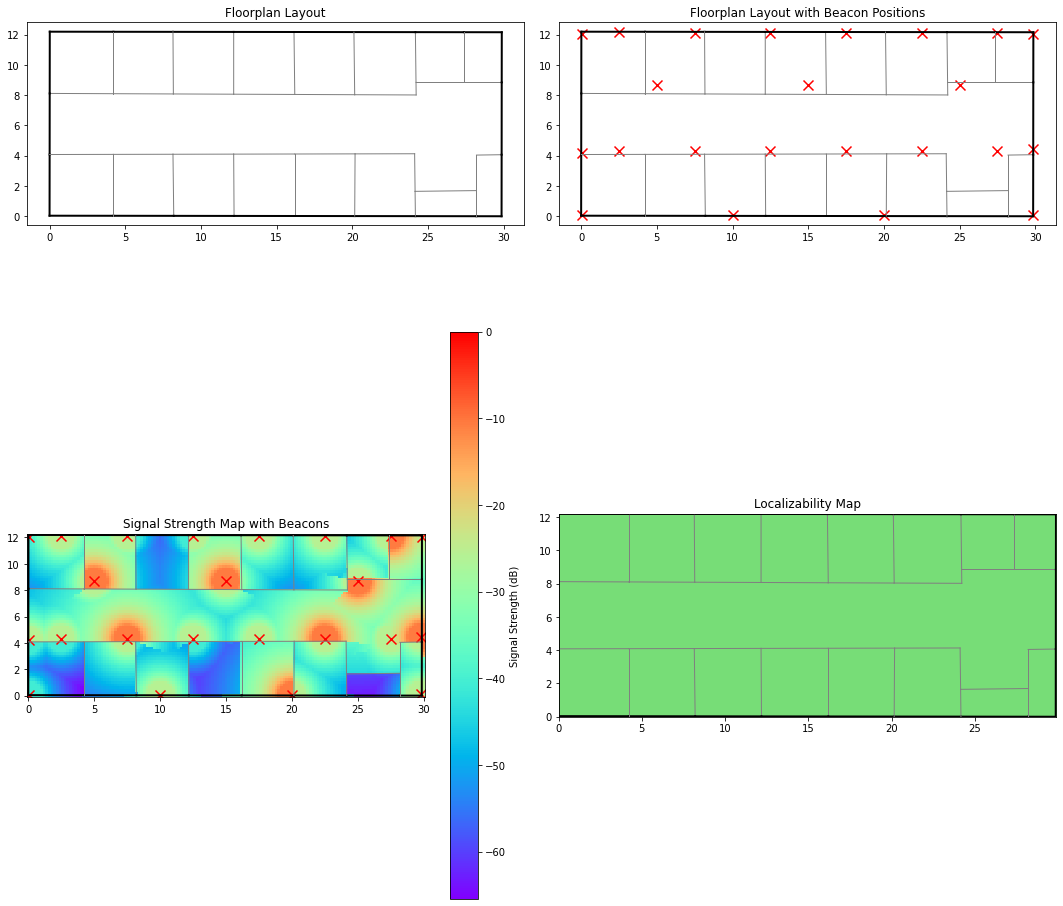

In [17]:
# Adjust the beacon powers
adjusted_beacon_powers = adjust_beacon_power(beacons, walls, POLY)

# Define the area for plotting
X = np.arange(MIN_X, MAX_X + step, step)
Y = np.arange(MIN_Y, MAX_Y + step, step)
X, Y = np.meshgrid(X, Y)

# Calculate the signal strength for each point in the layout considering all beacons
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        rx = (X[i,j], Y[i,j])
        strength = [signal_strength(beacon, rx, walls, Ptx) for beacon, Ptx in zip(beacons, adjusted_beacon_powers)]
        Z[i,j] = max(strength)  # Considering the strongest signal only

# Create a new figure and plot all the required plots in different subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))  # 2x2 grid of subplots

# Plot walls on the first subplot
plot_walls(axs[0, 0], walls)
axs[0, 0].set_title("Floorplan Layout")
axs[0, 0].set_aspect('equal', adjustable='box')

# Plot walls and beacon positions on the second subplot
plot_walls(axs[0, 1], walls)
plot_beacons(axs[0, 1], beacons)
axs[0, 1].set_title("Floorplan Layout with Beacon Positions")
axs[0, 1].set_aspect('equal', adjustable='box')

# Plot the coverage map on the third subplot
plot_walls(axs[1, 0], walls)
plot_coverage(axs[1, 0], X, Y, Z, vmin=sens, vmax=0)
plot_beacons(axs[1, 0], beacons)
axs[1, 0].set_title("Signal Strength Map with Beacons")
axs[1, 0].set_aspect('equal', adjustable='box')


# Plot the localizability map on the fourth subplot
plot_walls(axs[1, 1], walls)
plot_localizability_map(axs[1, 1], X, Y, beacons, walls, adjusted_beacon_powers, MIN_X, MAX_X, MIN_Y, MAX_Y)
axs[1, 1].set_title("Localizability Map")
axs[1, 1].set_aspect('equal', adjustable='box')

# Adjust spacing between subplots for clarity
plt.tight_layout()
plt.show()